## Import Modules

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

# Extract mae6292.zip
with zipfile.ZipFile('/Mae6292new.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/MAE6292')

# Verify extraction

print("Extracted files:", os.listdir('/content/MAE6292'))

Extracted files: ['imshow.py', 'tools.py', '__pycache__', '__init__.py']


In [ ]:
import sys
sys.path.append('/content/MAE6292new')

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import scipy.signal
import scipy.linalg
import MAE6292.tools as mae6292
import importlib

from MAE6292.imshow import cv2_imshow

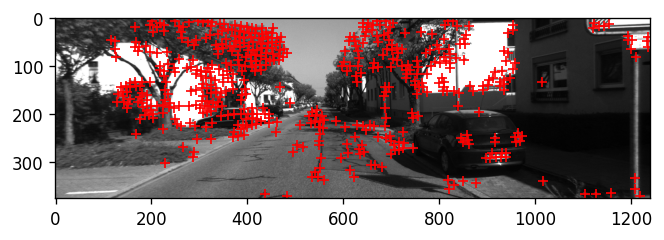

In [ ]:
img_database = cv2.imread('/000000.png',cv2.IMREAD_GRAYSCALE)
keypoints_database = list(map(tuple, np.loadtxt('/keypoints.txt', dtype='int')-1)) # list of (row, col)
K = np.loadtxt('/K.txt')
p_W_landmarks = np.loadtxt('/p_W_landmarks.txt').T

plt.figure(dpi=120)
plt.imshow(img_database,cmap='gray')
plt.plot(np.array(keypoints_database).T[1,:],np.array(keypoints_database).T[0,:],'r+')

In [ ]:
W_harris_patch = 4 # size of Harris patch
harris_kappa = 0.08 # parameters of Harris score
W_nms = 8 # size of non-maximum suppresion for keypoints seclection
W_descriptor = 9 # size of descriptor patch
lambda_match = 6 # paramter of descriptor matching
N_keypoint = 1000 # number of keypoints
N_iter = 1000 # number of RANSAC iteration
tol_inlier = 10 # tolerance of RANSIC inliner in pixels

# 1. imq_database: compute descriptor
descriptors_database = mae6292.describe_keypoints(img_database, keypoints_database, W_descriptor)

# 2. imq_query: load query image, detect keypoints, and compute descriptor
i_frame = 1
img_query_filename = "/000001.png".format(i_frame)
img_query = cv2.imread(img_query_filename,cv2.IMREAD_GRAYSCALE)
harris_score_query = mae6292.harris_corner(img_query, W_harris_patch, harris_kappa)
keypoints_query = mae6292.select_keypoints(harris_score_query, N_keypoint, W_nms)
descriptors_query = mae6292.describe_keypoints(img_query, keypoints_query, W_descriptor)

# 3. match descriptors
match, distance = mae6292.match_descriptors(descriptors_query, descriptors_database, lambda_match)
index_match = np.where(match>=0)[0].tolist()

# 4. extract matched keypoints and 3D world coordinates
keypoints_query_matched = [keypoints_query[i] for i in index_match]
keypoints_database_matched = [keypoints_database[match[i]] for i in index_match]
p_W_matched = p_W_landmarks[:, match[index_match]]

p_matched = np.array(keypoints_query_matched).T
p_matched = p_matched[[1,0],:]
p_matched = np.concatenate((p_matched, np.ones((1,p_matched.shape[1])) ), axis=0)
p_W_matched = p_W_landmarks[:, match[index_match]]
p_W_matched = np.concatenate((p_W_matched, np.ones((1,p_W_matched.shape[1])) ), axis=0)

# 5. estimate pose with RANSAC
R, T, M, N_inliers, i_inliers = mae6292.estimate_pose_RANSAC_DLT(p_matched, p_W_matched, K, N_iter, tol_inlier, display_iter=True)
print(-R.T@T)


i_iter=12, N_inliers=230, w=0.76
[[-0.00684574]
 [-0.01574125]
 [ 0.69763081]]


## Visualization

For the given estimated pose, the following codes visualize

1. the image frame with the matched keypoints
2. the top view of the estimated pose represented by an axes frame, and the keypoints, where the matched keypoints are denoted by a red marker

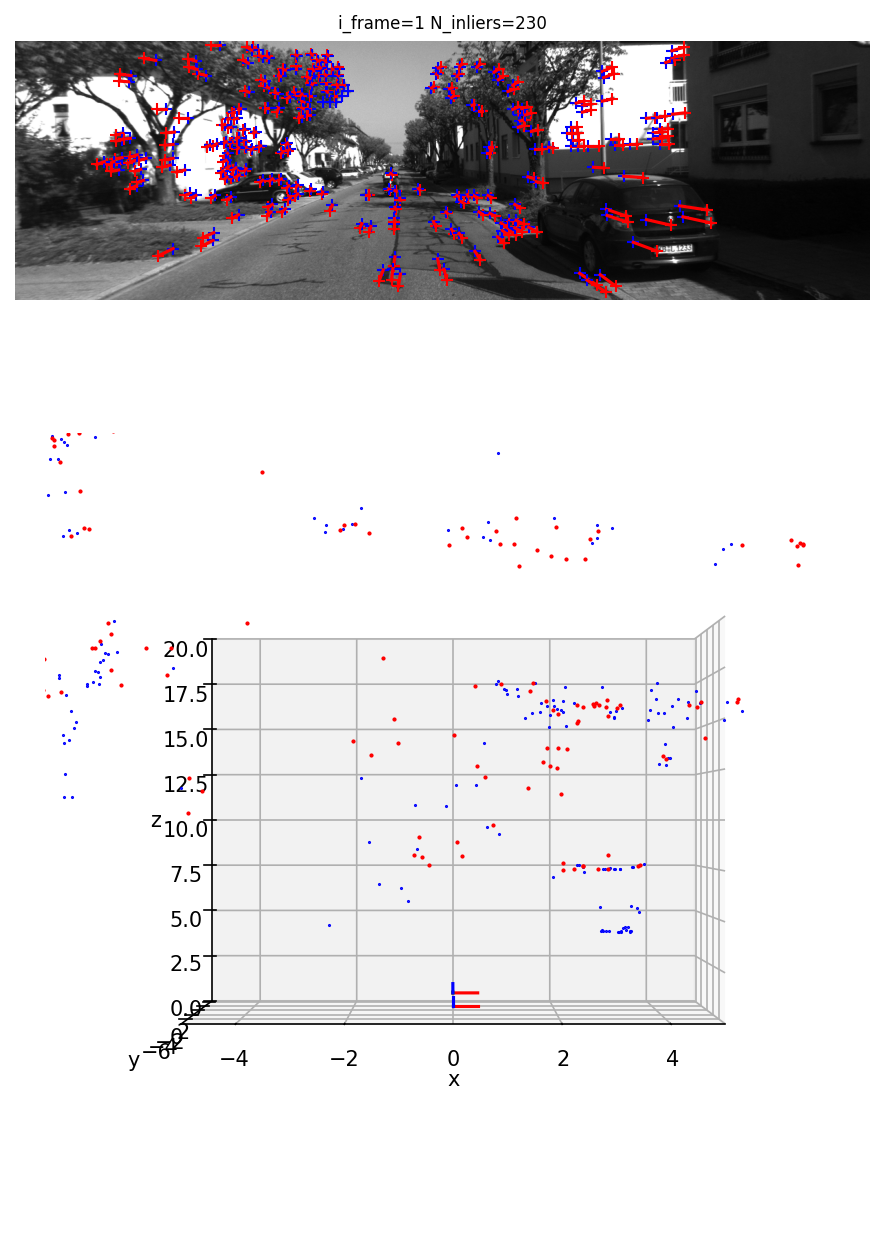

In [ ]:
%matplotlib inline
fig = plt.figure(dpi=150,figsize=(6,10))

fig.add_subplot(2, 1, 1)
plt.imshow(img_query,cmap='gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
for i in i_inliers:
    v_q, u_q = keypoints_query_matched[i] # matched keypoints on img1
    v_d, u_d = keypoints_database_matched[i] # matched keypoints on img
    plt.plot(u_q, v_q, 'r+')
    plt.plot(u_d, v_d, 'b+')
    plt.plot([u_d,u_q],[v_d,v_q],'r')
plt.title('i_frame='+str(i_frame)+' N_inliers='+str(N_inliers), fontsize=8)

ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.plot(p_W_landmarks[0,:],p_W_landmarks[1,:],p_W_landmarks[2,:],'b.',markersize=1)
ax.plot(p_W_matched[0,i_inliers],p_W_matched[1,i_inliers],p_W_matched[2,i_inliers],'ro',markersize=1)
ax.set_xlim(-5,5)
ax.set_zlim(0,20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0., azim=-90)
mae6292.draw_frame(ax, np.identity(3), np.zeros((3,1)),axis_length=0.5)
mae6292.draw_frame(ax, R,T,axis_length=0.5)
plt.tight_layout()


Frame 1: 63 inliers
Frame 2: 40 inliers
Frame 3: 32 inliers
Frame 4: 21 inliers
Frame 5: 13 inliers
Frame 6: 10 inliers
Frame 7: 6 inliers
Frame 8: 5 inliers
Frame 9: 6 inliers


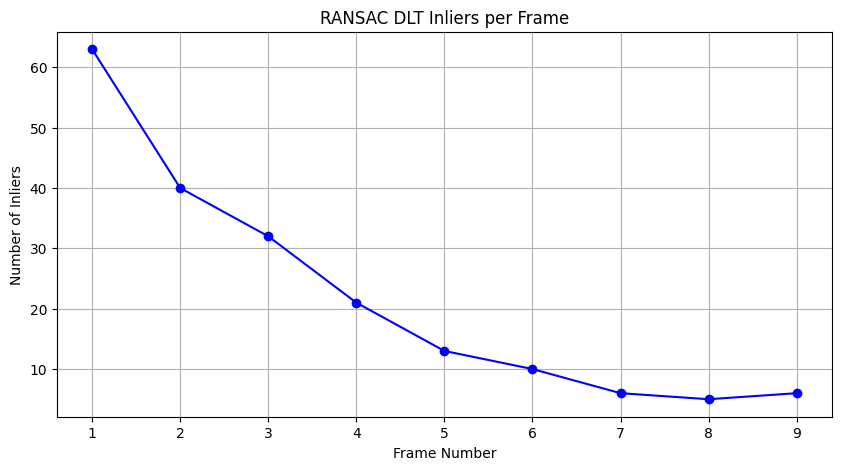

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Feature Extraction
def extract_features(img):
    sift = cv2.SIFT_create()
    kp, desc = sift.detectAndCompute(img, None)
    return np.array([k.pt for k in kp]), desc

# Feature Matching
def match_features(desc1, desc2, ratio_thresh=0.7):
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(desc1, desc2, k=2)
    good = []
    for m,n in matches:
        if m.distance < ratio_thresh*n.distance:
            good.append(m)
    return np.array(good)

# RANSAC DLT
def ransac_dlt(src_pts, dst_pts, thresh=3.0, max_iters=1000):
    best_inliers = []
    n_points = len(src_pts)

    for _ in range(max_iters):
        idx = np.random.choice(n_points, 4, replace=False)
        A = []

        for i in idx:
            x, y = src_pts[i]
            u, v = dst_pts[i]
            A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
            A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])

        _, _, V = np.linalg.svd(np.array(A))
        H = V[-1].reshape(3, 3)

        inliers = []
        for j in range(n_points):
            src = np.append(src_pts[j], 1)
            dst = np.append(dst_pts[j], 1)
            pred = H @ src
            pred = pred / pred[2]
            error = np.linalg.norm(pred - dst)
            if error < thresh:
                inliers.append(j)

        if len(inliers) > len(best_inliers):
            best_inliers = inliers

    return best_inliers


db_img = cv2.imread('/000000.png', cv2.IMREAD_GRAYSCALE)
db_kp, db_desc = extract_features(db_img)
p_W_landmarks = np.loadtxt('/p_W_landmarks.txt')

# Process frames
N_inliers = np.zeros(9, dtype=int)

for i_frame in range(1, 10):
    frame_path = f'/content/Images/{i_frame:06d}.png'
    frame_img = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

    if frame_img is None:
        print(f"Failed to load frame {i_frame}")
        continue

    frame_kp, frame_desc = extract_features(frame_img)
    matches = match_features(db_desc, frame_desc)

    if len(matches) < 4:
        print(f"Frame {i_frame}: Not enough matches ({len(matches)})")
        continue

    valid_matches = [m for m in matches if m.queryIdx < len(p_W_landmarks)]
    if len(valid_matches) < 4:
        print(f"Frame {i_frame}: Not enough valid 3D correspondences")
        continue

    matched_db_pts = np.float32([db_kp[m.queryIdx] for m in valid_matches])
    matched_frame_pts = np.float32([frame_kp[m.trainIdx] for m in valid_matches])

    # RANSAC DLT
    best_inliers = ransac_dlt(matched_db_pts, matched_frame_pts)
    N_inliers[i_frame-1] = len(best_inliers)
    print(f"Frame {i_frame}: {N_inliers[i_frame-1]} inliers")

# 6. Plot results
plt.figure(figsize=(10,5))
plt.plot(range(1,10), N_inliers, 'bo-')
plt.xlabel('Frame Number')
plt.ylabel('Number of Inliers')
plt.title('RANSAC DLT Inliers per Frame')
plt.xticks(range(1,10))
plt.grid(True)
plt.savefig('/content/prob1.png')


### (b) Discussion

Brifely discuss why the number of inliners decreases.

Why inliers decrease:

Viewpoint changes: Perspective distortion increases with camera movement, making feature matching harder.

Occlusions: Objects get blocked, reducing visible features.


Scene changes: New objects appear, altering feature visibility.

Matching errors: Feature matching isn't perfect, and errors accumulate.

Illumination/blur: Lighting and camera movement affect feature quality.

These factors lead to fewer reliable matches, thus fewer inliers for pose estimation.

In [ ]:
W_harris_patch = 4 # size of Harris patch
harris_kappa = 0.08 # parameters of Harris score
W_nms = 8 # size of non-maximum suppresion for keypoints seclection
W_descriptor = 9 # size of descriptor patch
lambda_match = 6 # paramter of descriptor matching
N_keypoint = 1900 # number of keypoints
N_iter = 900 # number of RANSAC iteration
tol_inlier = 10 # tolerance of RANSIC inliner in pixels

# 1. imq_database: compute descriptor
descriptors_database = mae6292.describe_keypoints(img_database, keypoints_database, W_descriptor)

# 2. imq_query: load query image, detect keypoints, and compute descriptor
i_frame = 9
img_query_filename = "/000009.png".format(i_frame)
img_query = cv2.imread(img_query_filename,cv2.IMREAD_GRAYSCALE)
harris_score_query = mae6292.harris_corner(img_query, W_harris_patch, harris_kappa)
keypoints_query = mae6292.select_keypoints(harris_score_query, N_keypoint, W_nms)
descriptors_query = mae6292.describe_keypoints(img_query, keypoints_query, W_descriptor)

# 3. match descriptors
match, distance = mae6292.match_descriptors(descriptors_query, descriptors_database, lambda_match)
index_match = np.where(match>=0)[0].tolist()

# 4. extract matched keypoints and 3D world coordinates
keypoints_query_matched = [keypoints_query[i] for i in index_match]
keypoints_database_matched = [keypoints_database[match[i]] for i in index_match]
p_W_matched = p_W_landmarks[match[index_match]]

p_matched = np.array(keypoints_query_matched).T
p_matched = p_matched[[1,0],:]
p_matched = np.concatenate((p_matched, np.ones((1,p_matched.shape[1])) ), axis=0)
p_W_matched = p_W_landmarks[match[index_match]]
p_W_matched = np.concatenate((p_W_matched.T, np.ones((1,p_W_matched.shape[0])) ), axis=0)

# 5. estimate pose with RANSAC
R, T, M, N_inliers, i_inliers = mae6292.estimate_pose_RANSAC_DLT(p_matched, p_W_matched, K, N_iter, tol_inlier, display_iter=True)
print(-R.T@T)


i_iter=57, N_inliers=2, w=0.01
N_inliners= 2  is less than 6. Failed to estimate the pose
[[0.]
 [0.]
 [0.]]


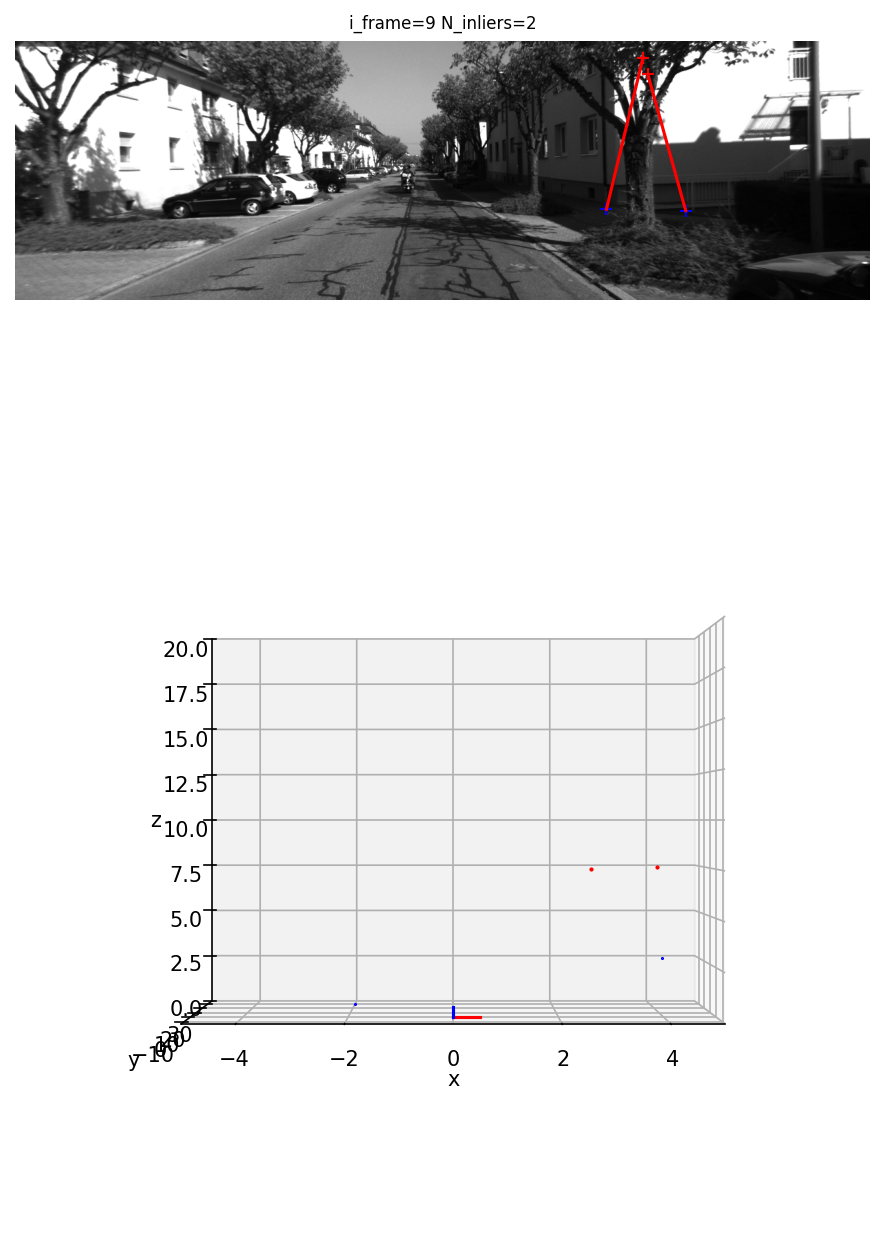

In [ ]:

%matplotlib inline
fig = plt.figure(dpi=150,figsize=(6,10))

fig.add_subplot(2, 1, 1)
plt.imshow(img_query,cmap='gray')
plt.xticks([]), plt.yticks([])
plt.axis('off')
for i in i_inliers:
    v_q, u_q = keypoints_query_matched[i]
    v_d, u_d = keypoints_database_matched[i]
    plt.plot(u_q, v_q, 'r+')
    plt.plot(u_d, v_d, 'b+')
    plt.plot([u_d,u_q],[v_d,v_q],'r')
plt.title('i_frame='+str(i_frame)+' N_inliers='+str(N_inliers), fontsize=8)

ax = fig.add_subplot(2, 1, 2, projection='3d')
ax.plot(p_W_landmarks[0,:],p_W_landmarks[1,:],p_W_landmarks[2,:],'b.',markersize=1)
ax.plot(p_W_matched[0,i_inliers],p_W_matched[1,i_inliers],p_W_matched[2,i_inliers],'ro',markersize=1)
ax.set_xlim(-5,5)
ax.set_zlim(0,20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=0., azim=-90)
mae6292.draw_frame(ax, np.identity(3), np.zeros((3,1)),axis_length=0.5)
mae6292.draw_frame(ax, R,T,axis_length=0.5)
plt.tight_layout()
plt
plt.savefig('/content/prob2_9.png')